<a href="https://colab.research.google.com/github/henry-heppe/SeminarML/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
!pip install optuna
!pip install git+https://github.com/JakeColtman/bartpy.git --no-deps

# Import Dependencies

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from bartpy.sklearnmodel import SklearnModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import lightgbm as lgb
import optuna

# Parameters

In [93]:
# Set the Seed
randomSeed = 100

# Number of Splits
numberSplits = 5

# Initialize DataFrame


In [81]:
# Load the data and remove object type data
boatsDF1 = pd.read_csv('1_df_nan.csv', sep= ',', index_col=0)
boatsDF2 = pd.read_csv('2_df_man.csv', sep= ',', index_col=0)
boatsDF3 = pd.read_csv('3_df_man_PCA.csv', sep= ',', index_col=0)
boatsDF4 = pd.read_csv('4_df_man_noNanCat.csv', sep= ',', index_col=0)
boatsDF5 = pd.read_csv('5_df_freq.csv', sep= ',', index_col=0)
boatsDF6 = pd.read_csv('6_df_freq_PCA.csv', sep= ',', index_col=0)
boatsDF7 = pd.read_csv('7_df_freq_noNanCat.csv', sep= ',', index_col=0)

# Dictionary of boat frames with NaN values
boatFramesWithNaN = {'df1': boatsDF1}

# Dictionary of boat frames without NaN values
boatFramesWithoutNaN = {'df2': boatsDF2, 'df3': boatsDF3, 'df4': boatsDF4, 'df5': boatsDF5, 'df6': boatsDF6, 'df7': boatsDF7}

# Dictionary of all boat frames
allBoatFrames = {'df1': boatsDF1, 'df2': boatsDF2, 'df3': boatsDF3, 'df4': boatsDF4, 'df5': boatsDF5, 'df6': boatsDF6, 'df7': boatsDF7}

# Parameter Optimization



In [95]:
X = boatsDF1.drop(['Price'], axis=1)
y = boatsDF1['Price']

def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'alpha': trial.suggest_float('alpha', 5, 15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }

    rmseTotal = 0
    kFold = KFold(n_splits= numberSplits, shuffle=True, random_state= randomSeed)

    for train_index, test_index in kFold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        threshold = np.quantile(y_train, 0.7)
        weights = np.where(y_train > threshold, 2.0, 1.0)

        # Define the model
        model = xgb.XGBRegressor(**param)

        # Train the model on the training set
        model.fit(X_train, y_train, sample_weight=weights)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Calculate and save the RMSE for this fold
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rmseTotal = rmseTotal + rmse

    rmseAverage = rmseTotal / numberSplits

    return -rmseAverage

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best trial: RMSE = {-study.best_value}")
print(f"Optimized parameters: {study.best_params}")

[I 2024-04-06 16:26:34,686] A new study created in memory with name: no-name-5037fb00-f3a8-4dff-833e-25a0801724b6
[I 2024-04-06 16:27:25,361] Trial 0 finished with value: -40341.699999906705 and parameters: {'colsample_bytree': 0.6265528923242114, 'learning_rate': 0.09292733270402989, 'max_depth': 12, 'alpha': 11.75963384152168, 'n_estimators': 160}. Best is trial 0 with value: -40341.699999906705.
[I 2024-04-06 16:27:30,176] Trial 1 finished with value: -43249.01932098011 and parameters: {'colsample_bytree': 0.7196716333665005, 'learning_rate': 0.036168960034027066, 'max_depth': 5, 'alpha': 10.884928736284126, 'n_estimators': 94}. Best is trial 0 with value: -40341.699999906705.
[I 2024-04-06 16:27:53,434] Trial 2 finished with value: -39852.1618414811 and parameters: {'colsample_bytree': 0.6870537000589969, 'learning_rate': 0.09639629443233443, 'max_depth': 10, 'alpha': 5.380706963971736, 'n_estimators': 120}. Best is trial 2 with value: -39852.1618414811.
[I 2024-04-06 16:28:00,319]

Best trial: RMSE = 38930.29697119105
Optimized parameters: {'colsample_bytree': 0.8502852690454983, 'learning_rate': 0.09629425921472178, 'max_depth': 8, 'alpha': 8.312775401869258, 'n_estimators': 164}


# XGBoost

In [96]:
rmseValuesXGBoost = {}
maeValuesXGBoost = {}

for name, boatFrame in allBoatFrames.items():
  X = boatFrame.drop(['Price'], axis=1)
  y = boatFrame['Price']
  rmseTotal = 0
  maeTotal = 0

  kFold = KFold(n_splits= numberSplits, shuffle=True, random_state= randomSeed)

  for train_index, test_index in kFold.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      threshold = np.quantile(y_train, 0.7)
      weights = np.where(y_train > threshold, 2.0, 1.0)

      # Define the model
      model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.85, learning_rate = 0.096,
                              max_depth = 8, alpha = 8.31, n_estimators = 164)

      # Train the model on the training set
      model.fit(X_train, y_train, sample_weight=weights)

      # Make predictions on the testing set
      y_pred = model.predict(X_test)

      # Calculate and save the RMSE for this fold
      mse = mean_squared_error(y_test, y_pred)
      rmse = np.sqrt(mse)
      rmseTotal = rmseTotal + rmse

      # Calculate and save the MAE for this fold
      mae = mean_absolute_error(y_test, y_pred)
      maeTotal = maeTotal + mae

  rmseAverage = rmseTotal / numberSplits
  maeAverage = maeTotal / numberSplits
  rmseValuesXGBoost[f'rmse_value_{name}'] = rmseAverage
  maeValuesXGBoost[f'mae_value_{name}'] = maeAverage

print(list(rmseValuesXGBoost.keys()))
print(list(rmseValuesXGBoost.values()))
print(list(maeValuesXGBoost.keys()))
print(list(maeValuesXGBoost.values()))

['rmse_value_df1', 'rmse_value_df2', 'rmse_value_df3', 'rmse_value_df4', 'rmse_value_df5', 'rmse_value_df6', 'rmse_value_df7']
[39236.96852929885, 39522.79583546046, 39933.475455101165, 39629.3795418613, 39461.35662393279, 39898.549465551114, 39372.278347449]
['mae_value_df1', 'mae_value_df2', 'mae_value_df3', 'mae_value_df4', 'mae_value_df5', 'mae_value_df6', 'mae_value_df7']
[23378.732219079422, 23510.27271705715, 23804.6338619908, 23524.706034709514, 23610.786629162125, 24056.77105094958, 23612.748616502864]


# Light GBM

In [97]:
rmseValuesLGBM = {}
maeValuesLGBM = {}

for name, boatFrame in allBoatFrames.items():
  X = boatFrame.drop(['Price'], axis=1)
  y = boatFrame['Price']
  rmseTotal = 0
  maeTotal = 0

  kFold = KFold(n_splits= numberSplits, shuffle=True, random_state= randomSeed)

  for train_index, test_index in kFold.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      threshold = np.quantile(y_train, 0.7)
      weights = np.where(y_train > threshold, 2.0, 1.0)

      # Define the model
      model = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves= 256, colsample_bytree = 0.85, max_depth= 8,
                             learning_rate= 0.096, n_estimators= 164, subsample_for_bin=200000,
                             reg_alpha = 8.31, random_state=randomSeed, verbose=-1)

      # Train the model on the training set
      model.fit(X_train, y_train, sample_weight=weights)

      # Make predictions on the testing set
      y_pred = model.predict(X_test)

      # Calculate and save the RMSE for this fold
      mse = mean_squared_error(y_test, y_pred)
      rmse = np.sqrt(mse)
      rmseTotal = rmseTotal + rmse

      # Calculate and save the MAE for this fold
      mae = mean_absolute_error(y_test, y_pred)
      maeTotal = maeTotal + mae

  rmseAverage = rmseTotal / numberSplits
  maeAverage = maeTotal / numberSplits
  rmseValuesLGBM[f'rmse_value_{name}'] = rmseAverage
  maeValuesLGBM[f'mae_value_{name}'] = maeAverage

print(list(rmseValuesLGBM.keys()))
print(list(rmseValuesLGBM.values()))
print(list(maeValuesLGBM.keys()))
print(list(maeValuesLGBM.values()))

['rmse_value_df1', 'rmse_value_df2', 'rmse_value_df3', 'rmse_value_df4', 'rmse_value_df5', 'rmse_value_df6', 'rmse_value_df7']
[39595.659065802596, 39758.71477428215, 39607.71982179379, 39764.59860947528, 39621.286013735255, 39657.53294411556, 39791.61742584813]
['mae_value_df1', 'mae_value_df2', 'mae_value_df3', 'mae_value_df4', 'mae_value_df5', 'mae_value_df6', 'mae_value_df7']
[23900.16471834062, 23957.04246842853, 23877.166664528246, 23947.84202101162, 23975.5465739197, 24040.994099128893, 24062.547172851842]


# Random Forest

In [ ]:
rmseValuesRF = {}
maeValuesRF = {}

for name, boatFrame in boatFramesWithoutNaN.items():
  X = boatFrame.drop(['Price'], axis=1)
  y = boatFrame['Price']
  rmseTotal = 0
  maeTotal = 0

  kFold = KFold(n_splits=numberSplits, shuffle=True, random_state= randomSeed)

  for train_index, test_index in kFold.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      threshold = np.quantile(y_train, 0.7)
      weights = np.where(y_train > threshold, 2.0, 1.0)

      # Define the model
      model =RandomForestRegressor(n_estimators=200, random_state=randomSeed, n_jobs=-1)

      # Train the model on the training set
      model.fit(X_train, y_train, sample_weight=weights)

      # Make predictions on the testing set
      y_pred = model.predict(X_test)

      # Calculate and save the RMSE for this fold
      mse = mean_squared_error(y_test, y_pred)
      rmse = np.sqrt(mse)
      rmseTotal = rmseTotal + rmse

      # Calculate and save the MAE for this fold
      mae = mean_absolute_error(y_test, y_pred)
      maeTotal = maeTotal + mae

  rmseAverage = rmseTotal / numberSplits
  maeAverage = maeTotal / numberSplits
  rmseValuesRF[f'rmse_value_{name}'] = rmseAverage
  maeValuesRF[f'mae_value_{name}'] = maeAverage

print(list(rmseValuesRF.keys()))
print(list(rmseValuesRF.values()))
print(list(maeValuesRF.keys()))
print(list(maeValuesRF.values()))

# Bayesian Additive Regression Trees

In [ ]:
rmseValuesBART = {}
maeValuesBART = {}

for name, boatFrame in boatFramesWithoutNaN.items():
  X = boatFrame.drop(['Price'], axis=1)
  y = boatFrame['Price']
  rmseTotal = 0
  maeTotal = 0

  kFold = KFold(n_splits= numberSplits, shuffle=True, random_state= randomSeed)

  for train_index, test_index in kFold.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # Define the model
      model = SklearnModel(n_jobs=1, n_chains= 2)

      # Train the model on the training set
      model.fit(X_train, y_train)

      # Make predictions on the testing set
      y_pred = model.predict(X_test)

      # Calculate and save the RMSE for this fold
      mse = mean_squared_error(y_test, y_pred)
      rmse = np.sqrt(mse)
      rmseTotal = rmseTotal + rmse

      # Calculate and save the MAE for this fold
      mae = mean_absolute_error(y_test, y_pred)
      maeTotal = maeTotal + mae

  rmseAverage = rmseTotal / numberSplits
  maeAverage = maeTotal / numberSplits
  rmseValuesBART[f'rmse_value_{name}'] = rmseAverage
  maeValuesBART[f'mae_value_{name}'] = maeAverage

print(list(rmseValuesBART.keys()))
print(list(rmseValuesBART.values()))
print(list(maeValuesBART.keys()))
print(list(maeValuesBART.values()))

# Plotting Time


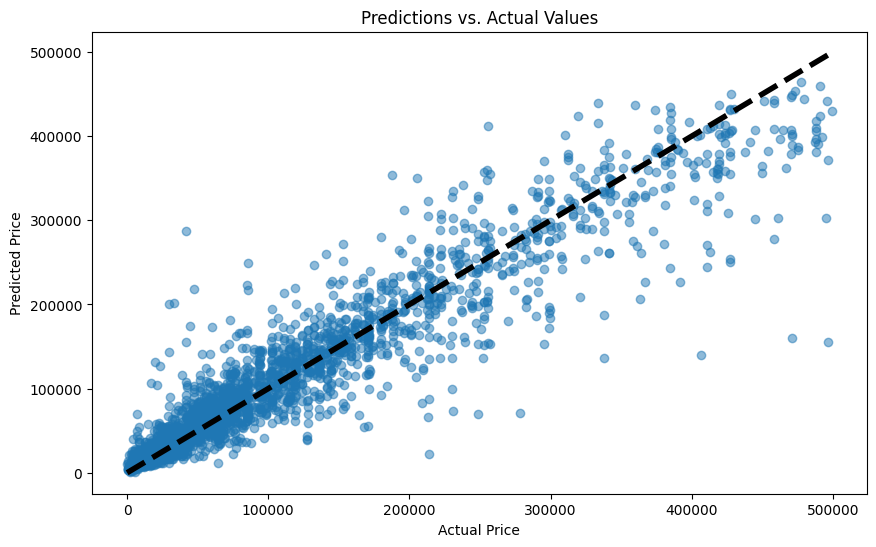

In [14]:
# Make an Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predictions vs. Actual Values')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()